<a href="https://colab.research.google.com/github/ibonetc/AI_Deep-Learning/blob/main/IA_DL_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

Un autoencoder es un algoritmo para compresión y descompresión de datos, con la paticularidad es capaz de reprodicir sólo datos similares a los que aprende. Lo más común es verlo como una red neuronal convolucional.

Se divide en dos componentes:

*   Encoder: Es el módulo encargado de comprimir los datos a un espacio latente
*   Decoder: Es el módulo encargado de descomprimir los datos, tratando de reconstruir la entrada original.





Los codificadores automáticos tienen pérdidas, lo que significa que las salidas descomprimidas se degradarán en comparación con las entradas originales.

En este ejemplo vamos a usar la base de datos MNIST para demostrar el uso de eliminación de ruido.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

## Cargando los datos
- Acá cada imagen tiene un tamaño de 28x28, lo que significa una entrada de 784

In [ ]:
(x_train,_),(x_test,_)= mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


### Reshape

Adicionar la tercera dimensión de la imagen (En las imágenes a color no es necesario hacer esto).

train_data= np.reshape(x_train, (len(x_train), 28, 28, 1))
test_data= np.reshape(x_test, (len(x_test), 28, 28, 1))

Otra opción de Reshape

train_data = x_train[..., tf.newaxis]
test_data = x_test[..., tf.newaxis]

In [ ]:
train_data= np.reshape(x_train, (len(x_train), 28, 28, 1))
test_data= np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
print(train_data.shape)
print(test_data.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Ejemplo de eliminación de ruido

Para esto, vamos a crear unas imágenes con ruido a partir de las originales, para probar que el modelo sea capaz de reconstruir la imagen.

Se creará un encoder que comprima la imagen de una dimensión de 784 a 32 y un módulo decoder que la vuelva a **reconstruir**

### Crear imágenes con ruido

In [ ]:
noisy_train_data = train_data + 0.7*np.random.normal(loc=0.0, scale=1.0, size=train_data.shape)
noisy_train_data = np.clip(noisy_train_data, 0., 1.)

noisy_test_data = test_data + 0.7*np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
noisy_test_data= np.clip(noisy_test_data, 0., 1.)

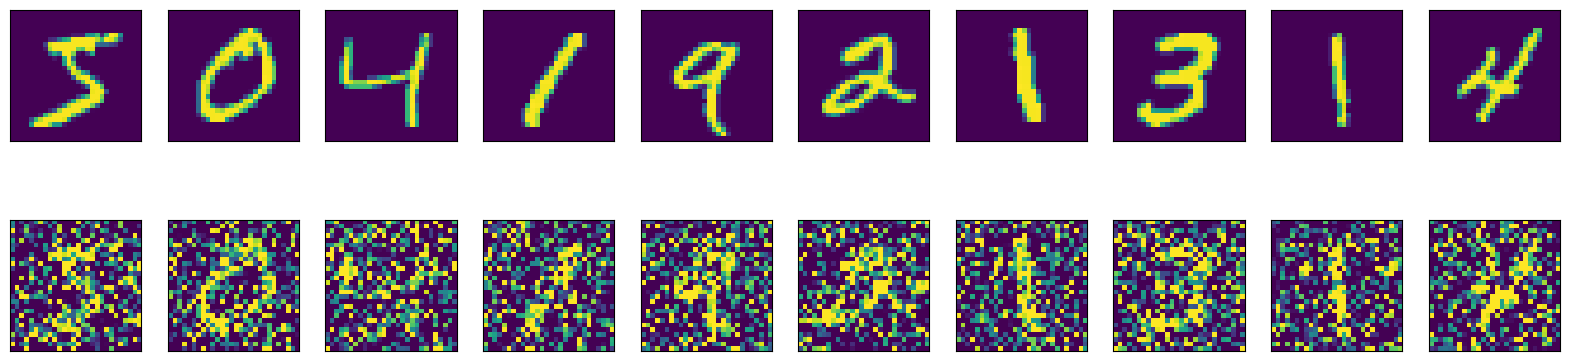

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(10):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(train_data[i].reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 +10)
  plt.imshow(noisy_train_data[i].reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

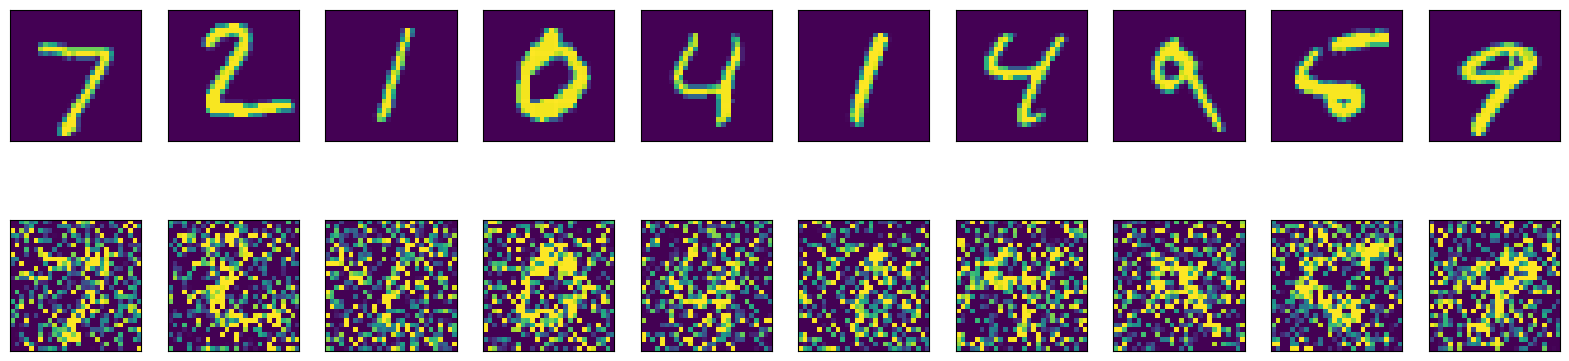

In [ ]:
plt.figure(figsize=(20, 5))
for i in range(10):
  ax = plt.subplot(2, 10, i + 1)
  plt.imshow(test_data[i].reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(2, 10, i + 1 +10)
  plt.imshow(noisy_test_data[i].reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Modelo autoencoder

In [ ]:
input= Input(shape=(28,28,1))

# Encoder
encoder= Conv2D(64, (3,3), activation='relu', padding='same')(input)
encoder= MaxPooling2D((2,2), padding='same')(encoder)
encoder= Conv2D(32, (3,3), activation='relu', padding='same')(encoder)
encoder= MaxPooling2D((2,2), padding='same')(encoder)

# Decoder
decoder= Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(encoder)
decoder= Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(decoder)
decoder= Conv2D(1, (3,3), activation='sigmoid', padding='same')(decoder)

#Autoencoder

autoencoder= Model(input, decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,425 (185.25 KB)

 Trainable params: 47,425 (185.25 KB)

 Non-trainable params: 0 (0.00 B)

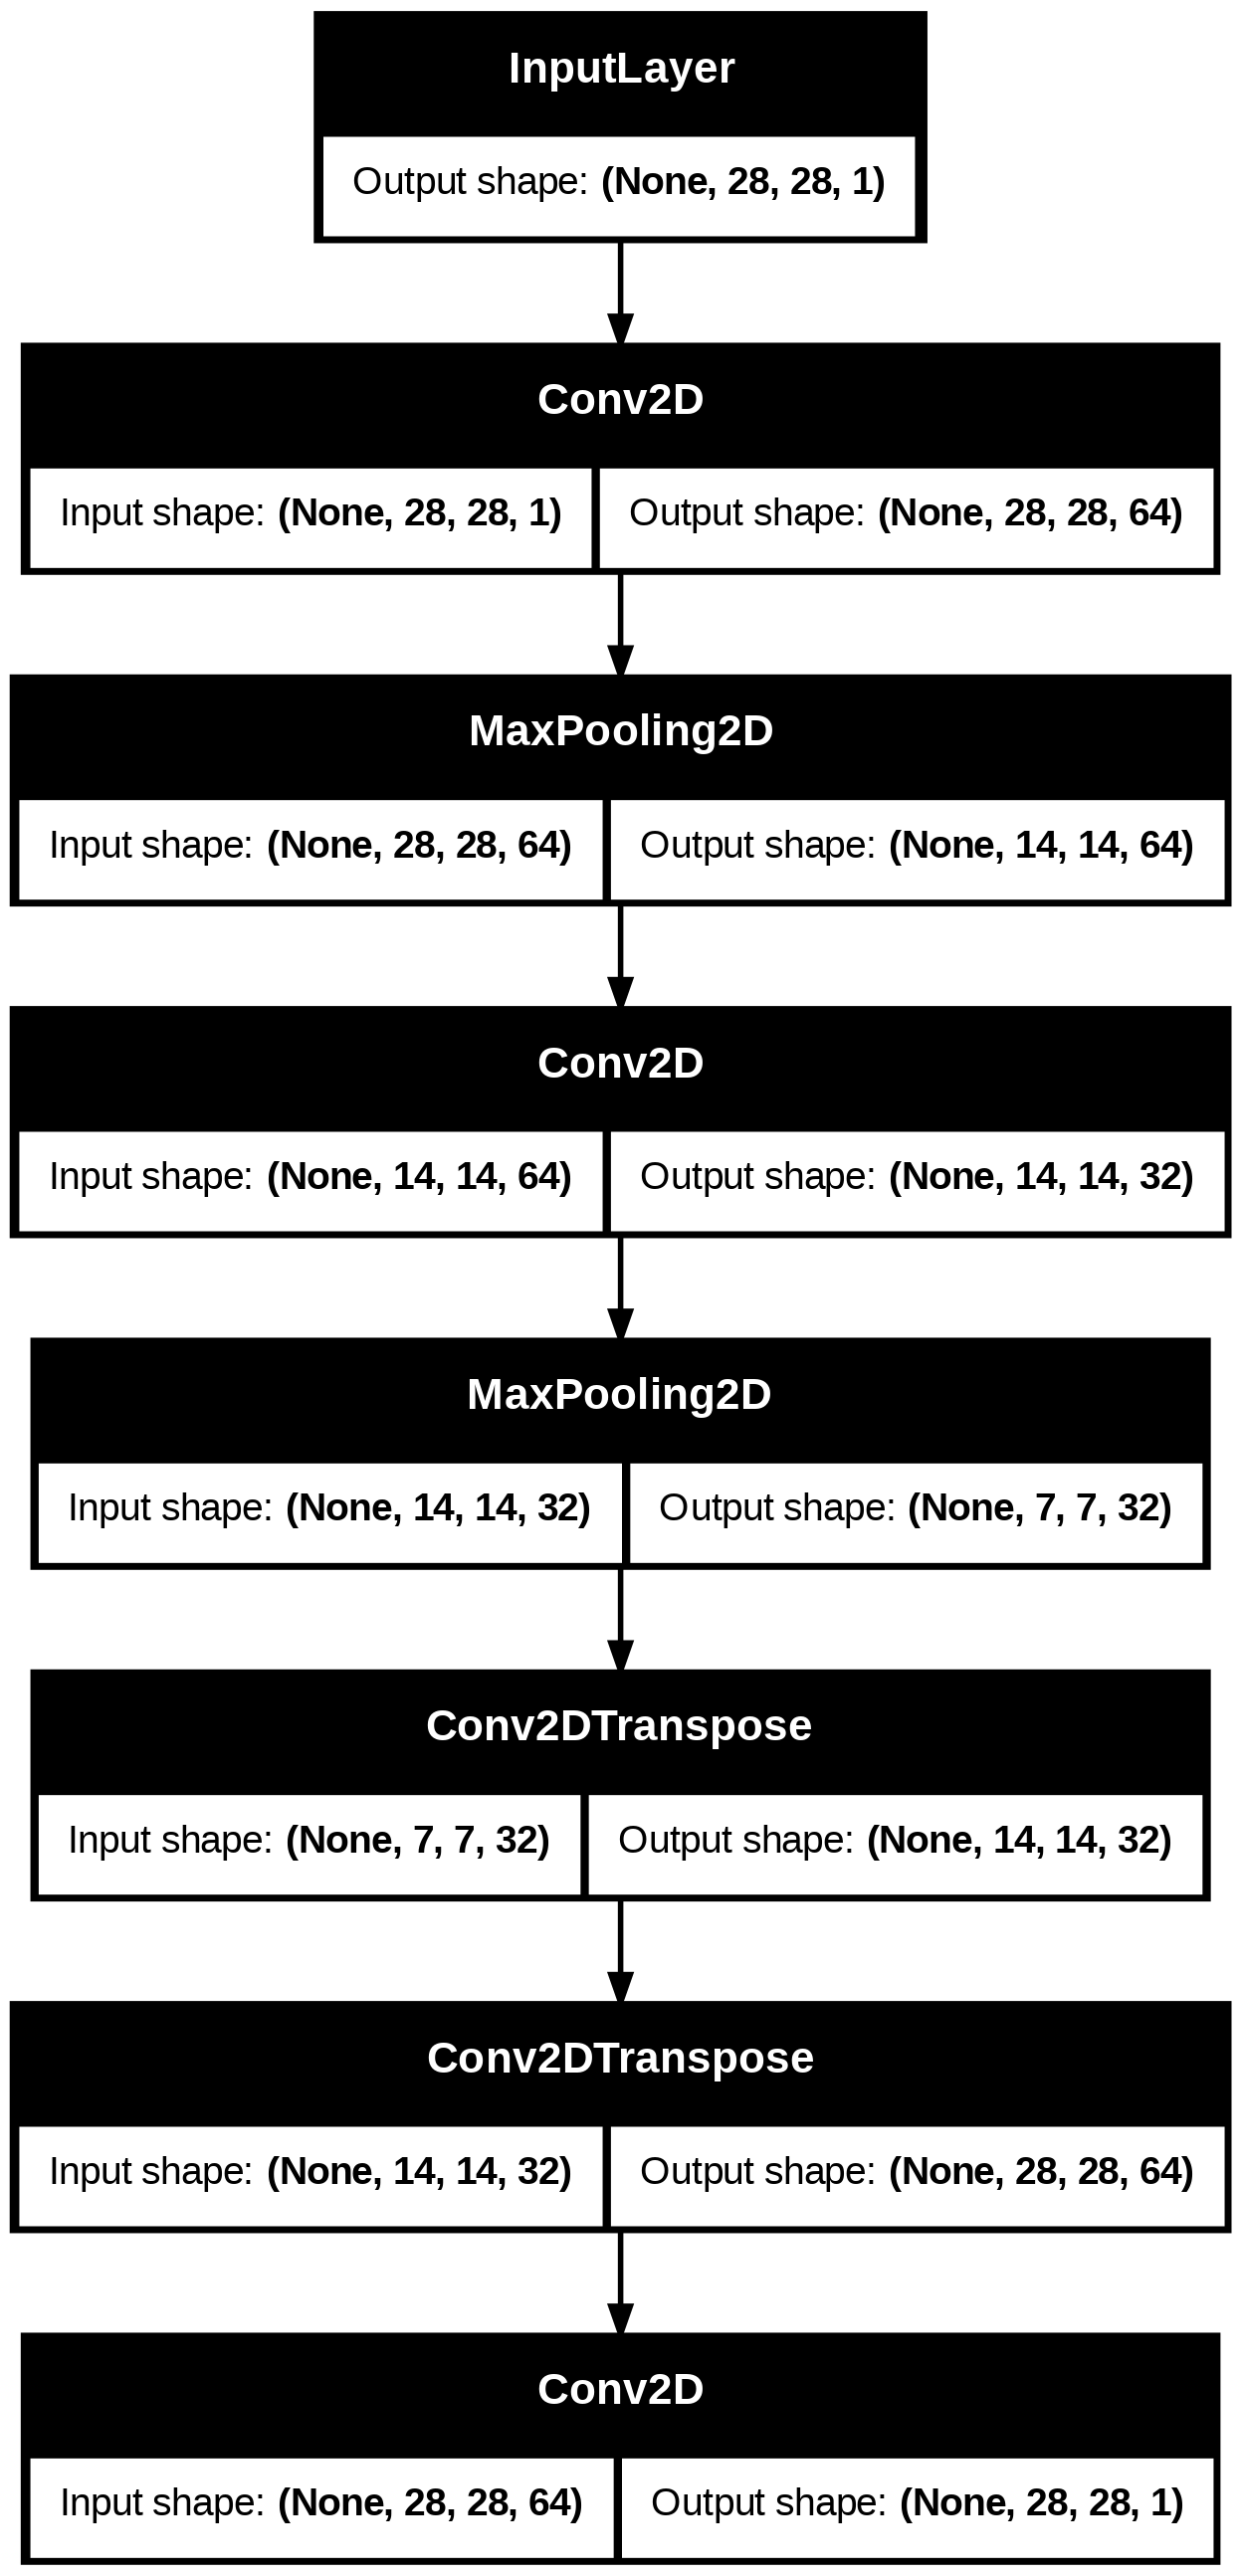

In [ ]:
plot_model(autoencoder, show_shapes=True)

In [ ]:
filepath='autoencoder_noisy_model_epoch{epoch:02d}-loss{loss:.2f}.keras'
model_checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    save_best_only=True,
    mode='min',
    save_freq='epoch')

In [ ]:
autoencoder.fit(x=noisy_train_data,
                y=train_data,
                epochs=50,
                batch_size=128,
                shuffle=True,
                callbacks=[model_checkpoint])

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.2991
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.1466
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1404
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1368
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1344
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1328
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1313
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1301
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1293
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1286
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1277
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1273
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1267
Epoch 14/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1261
Epoch 15/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - l

In [ ]:
predictions= autoencoder.predict(noisy_test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


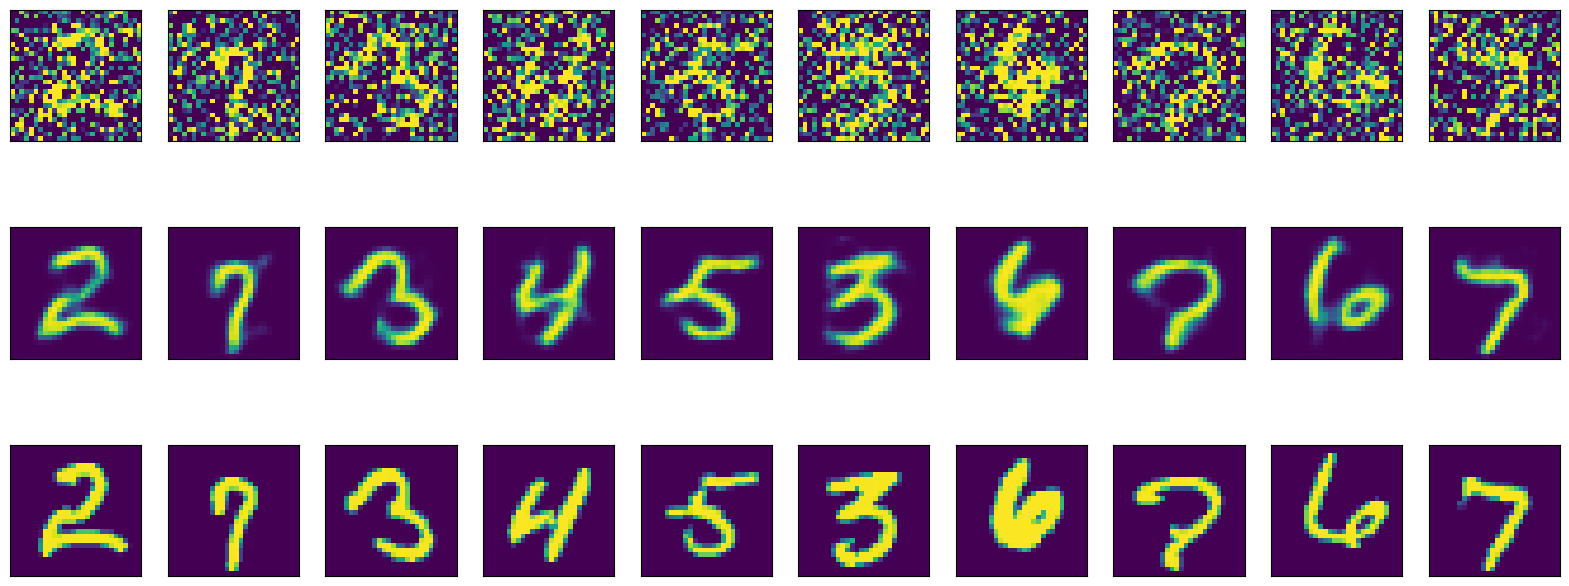

In [ ]:
indeces = np.random.randint(len(noisy_test_data), size=10)
images_noisy= noisy_test_data[indeces]
images_denoised= predictions[indeces]
images_original= test_data[indeces]

plt.figure(figsize=(20, 8))
for i, (image1,image2,image3) in enumerate(zip(images_noisy, images_denoised, images_original)):
  ax = plt.subplot(3, 10, i +1)
  plt.imshow(image1.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax= plt.subplot(3, 10, i + 11)
  plt.imshow(image2.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax= plt.subplot(3, 10, i + 21)
  plt.imshow(image3.reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Ejemplo de detección de anomalías

Para esto utilizaremos un ejemplo [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). Esta base de datos tiene 5000 electrocardiogramas, donde cada uno tiene 140 puntos. Los casos están etiquetados, donde 0 significa ritmo no normal y 1 ritmo normal.

La idea es poder identificar los ritmos con anomalías (no normales).

Este ejemplo, al ser supervisado se puede tratar con cualquier método de clasificación. Aquí la idea es mostrar un ejemplo donde, partiendo de un modelo que se entrene con casos de ritmo normal, sea capaz de identificar cuando no es normal.

### Cargar los datos

In [ ]:
df= pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
values_data=df.values
df

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


In [ ]:
print(np.unique(values_data[:,-1],return_counts=True))

(array([0., 1.]), array([2079, 2919]))


## Normalizar datos

In [ ]:
values_data.shape

(4998, 141)

In [ ]:
labels= values_data[:,-1]
data= values_data[:,0:-1]

In [ ]:
min_val= tf.reduce_min(data)
max_val= tf.reduce_max(data)
print(min_val,max_val)

tf.Tensor(-7.0903741, shape=(), dtype=float64) tf.Tensor(7.4021031, shape=(), dtype=float64)


In [ ]:
train_data, test_data, train_labels, test_labels= train_test_split(data, labels, test_size=0.2, random_state=21,stratify=labels)

In [ ]:
train_data= (train_data-min_val)/(max_val-min_val)
test_data= (test_data-min_val)/(max_val-min_val)
train_data= tf.cast(train_data, tf.float32)
test_data= tf.cast(test_data, tf.float32)

In [ ]:
train_labels==1

array([ True,  True, False, ..., False,  True, False])

In [ ]:
one_train_data= train_labels==1
one_test_data= test_labels==1

In [ ]:
normal_train_data= train_data[one_train_data]
normal_test_data= test_data[one_test_data]

anomalous_train_data= train_data[train_labels==0]
anomalous_test_data= test_data[test_labels==0]

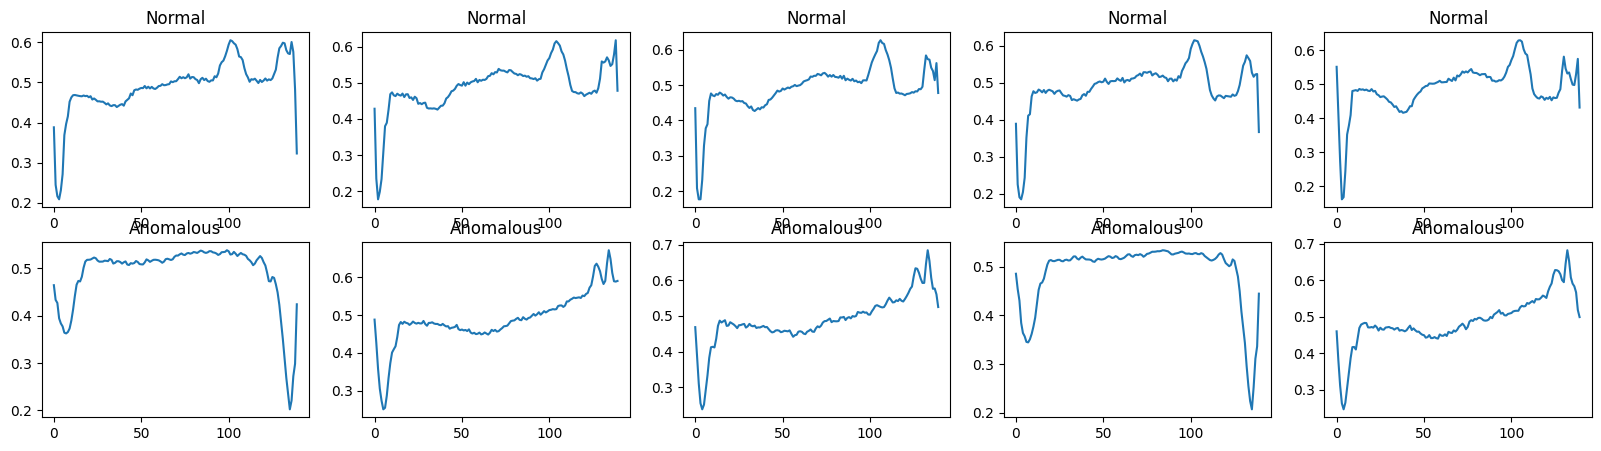

In [ ]:
plt.figure(figsize=(20, 5))
for i, (v1,v2) in enumerate(zip(normal_train_data[:5], anomalous_train_data[:5])):
  ax = plt.subplot(2,5,i+1)
  plt.plot(np.arange(140),v1)
  plt.title('Normal')
  ax = plt.subplot(2,5,i+6)
  plt.plot(np.arange(140),v2)
  plt.title('Anomalous')

In [ ]:
input= Input(shape=(140,))

# Encoder
encoder= Dense(32, activation='relu')(input)
encoder= Dense(16, activation='relu')(encoder)
encoder= Dense(8, activation='relu')(encoder)
# Decoder
decoder= Dense(16, activation='relu')(encoder)
decoder= Dense(32, activation='relu')(decoder)
decoder= Dense(140, activation='sigmoid')(decoder)

autoencoder= Model(input, decoder)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 140)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 140)                 │           4,620 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,484 (40.95 KB)

 Trainable params: 10,484 (40.95 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history= autoencoder.fit(x=normal_train_data,
                y=normal_train_data,
                epochs=100,
                batch_size=256,
                shuffle=True)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0118 
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0119 
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0116 
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0118 
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117  
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116  
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - l

In [ ]:
autoencoder.save('autoencoder_ecg.keras')

Text(0, 0.5, 'Loss')

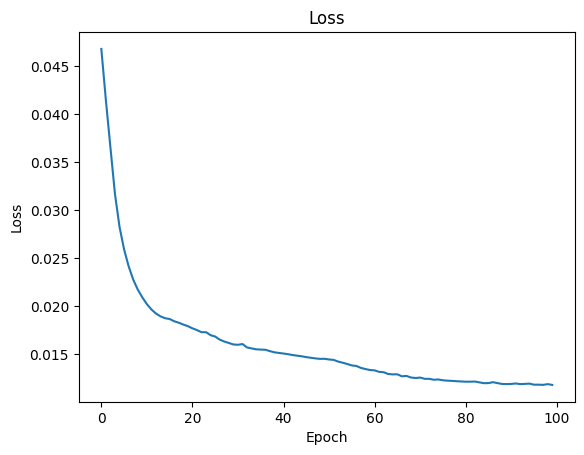

In [ ]:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
predictions= autoencoder.predict(normal_test_data)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


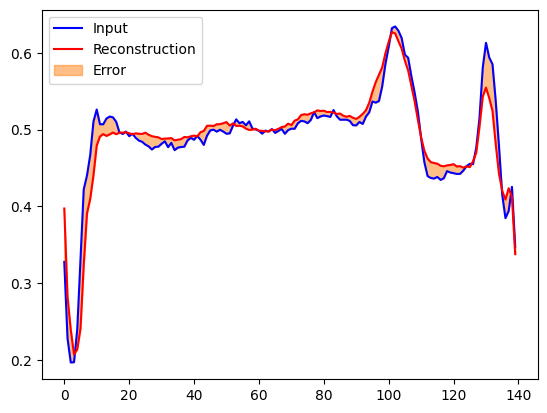

In [ ]:
plt.plot(normal_test_data[0], 'b')
plt.plot(predictions[0], 'r')
plt.fill_between(np.arange(140), predictions[0], normal_test_data[0], color='tab:orange', alpha=0.5)
plt.legend(['Input', 'Reconstruction', 'Error'])
plt.show()

In [ ]:
predictions_anomalous= autoencoder.predict(anomalous_test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


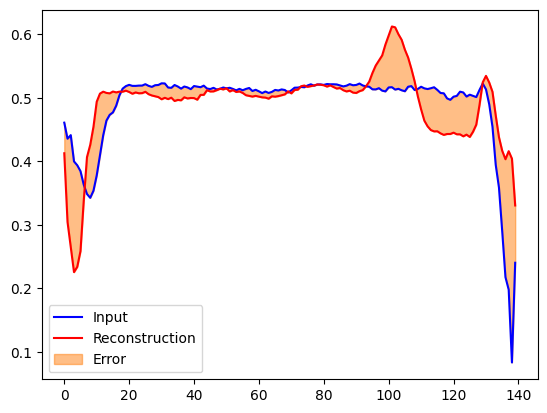

In [ ]:
plt.plot(anomalous_test_data[0], 'b')
plt.plot(predictions_anomalous[0], 'r')
plt.fill_between(np.arange(140), predictions_anomalous[0], anomalous_test_data[0], color='tab:orange', alpha=0.5)
plt.legend(['Input', 'Reconstruction', 'Error'])
plt.show()

## Detección de anomalías

In [ ]:
reconstruction_normal= autoencoder.predict(normal_train_data)
reconstruction_anomalous= autoencoder.predict(anomalous_train_data)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
train_loss_normal= tf.keras.losses.mae(reconstruction_normal, normal_train_data)
train_loss_anomalous= tf.keras.losses.mae(reconstruction_anomalous, anomalous_train_data)

In [ ]:
train_loss_normal

<tf.Tensor: shape=(2335,), dtype=float32, numpy=
array([0.01313719, 0.00720365, 0.01083675, ..., 0.00822003, 0.01037595,
       0.01060496], dtype=float32)>

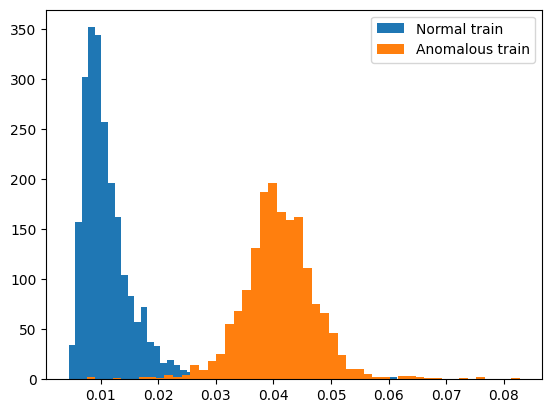

In [ ]:
plt.hist(train_loss_normal[None,:], bins=50, label='Normal train')
plt.hist(train_loss_anomalous[None,:], bins=50, label='Anomalous train')
plt.legend()
plt.show()

In [ ]:
threshold= np.mean(train_loss_normal)+2*np.std(train_loss_normal)
print(threshold)

0.0251700421795249


## Validación

In [ ]:
reconstruction_test= autoencoder.predict(test_data)
loss= tf.keras.losses.mae(reconstruction_test, test_data)
predictions=[1 if loss<threshold else 0]#tf.math.less(loss, threshold)
predictions

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<tf.Tensor: shape=(1000,), dtype=bool, numpy=
array([False, False, False,  True,  True,  True, False, False, False,
        True, False,  True, False,  True,  True, False, False,  True,
        True,  True, False,  True, False,  True, False, False,  True,
       False,  True,  True, False, False,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True, False, False,
       False,  True,  True, False, False,  True,  True, False, False,
       False, False,  True,  True, False, False, False, False,  True,
       False, False, False,  True, False, False,  True,  True, False,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
        True, False, False, False, False,  True, False, False,  True,
       False, False,  True, False,  True,  True,  True, False, False,
       False,  True,  True,  True, False,  True, False, False,  True,
        True, False, False,  True,  True,  T

In [ ]:
test_labels

array([0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 1., 0.

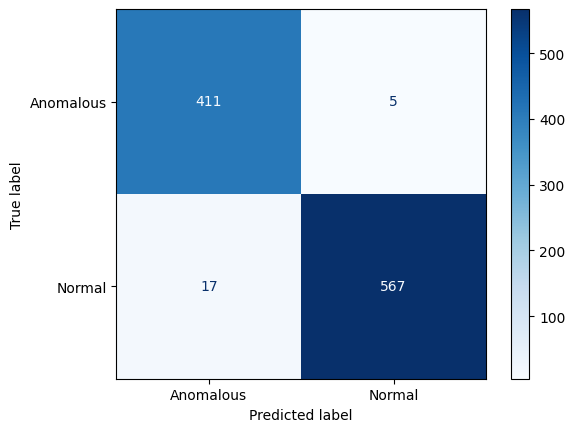

In [ ]:
cm= confusion_matrix(test_labels, predictions)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomalous','Normal'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       416
         1.0       0.99      0.97      0.98       584

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

